# Predict C-to-U editing sites from a FASTA file

## Environment

In [1]:
import numpy as np
import sklearn.metrics

import matplotlib.pyplot as plt
import sklearn.metrics as metrics

### Deepred-Mt installation

In [2]:
!pip install -U "deepredmt @ git+https://github.com/aedera/deepredmt.git" > /dev/null

  Running command git clone -q https://github.com/aedera/deepredmt.git /tmp/pip-install-qmb9hdsn/deepredmt


## Data

To show how to use Deepred-Mt, we will download a FASTA file which contains sequences of mitochondrial protein-coding genes of a flowering plant.

In [3]:
!wget https://raw.githubusercontent.com/aedera/deepredmt/main/data/seqs.fas

--2021-05-21 15:51:44--  https://raw.githubusercontent.com/aedera/deepredmt/main/data/seqs.fas
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32597 (32K) [text/plain]
Saving to: ‘seqs.fas.5’

seqs.fas.5          100%[===================>]  31.83K  --.-KB/s    in 0s      

2021-05-21 15:51:44 (93.6 MB/s) - ‘seqs.fas.5’ saved [32597/32597]



## Make predictions

Now, we will use Deepred-Mt to predict C-to-U editing sites in our FASTA file.

In [4]:
!deepredmt seqs.fas > seqs.pred

2021-05-21 15:51:45.265085: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-21 15:51:47.968558: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-21 15:51:47.969736: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-21 15:51:47.981946: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-21 15:51:47.982012: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cd6c5ed00325): /proc/driver/nvidia/version does not exist
2021-05-21 15:51:47.982626: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-21 15:51:55.204728: I tensorflow/compiler/mlir/mlir_graph_optimizati

In this command, Deepred-Mt scans the input FASTA file for cytidines (Cs), or already annotated editing sites (Es). Next, for each C or E found, it calculates a prediction score by using their surrounding nucleotides.

The output of Deepred-Mt is saved in a file named `seqs.pred`. We can inspect the format of this output file by taking ten random file entries.

In [5]:
!shuf seqs.pred | head -10 | column -t

nad3!255           CCTTGGGCAGTCTCTCTCAA  C  AAGATTGATCEGTTTGGATE  0.001
nad4!577           CTATTCTGTTGATTETTCTC  C  AAATAGGAACCACCGATTTA  0.003
KU992338_rps4!727  GAATGAAGAGAAATTTTTAT  C  ATTTAAAATCCCTATTCTTA  0.365
nad1!623           TCCATTTGATCTCCCAGAAG  C  GGAAGCTGAATEAGTTGCAG  0.002
KU992338_rps4!739  ATTTTTATCATTTAAAATCC  C  TATTCTTATTAAAGAGAAGA  0.024
KU992362_atp1!440  ACGTAAATCTGTGCACGAGC  C  TATGCAAACAGGGTTAAAAG  0.007
nad1!742           GTCEATGCACATTGCTCTET  C  EAGGGGGTTGGCEGCCTATC  0.034
ccmb!54            CATAAACAGATETTCECCTC  C  ACACEAATCACGAGTTTTTC  0.143
KU992362_atp1!94   GGAAAGTGGATGAGATEGGT  C  GAGTGGTGTCCGTTGGAGAT  0.029
nad2!1345          GGACATGGATTTTATATGAA  C  CCATGGATCGTGACAAGTCG  0.005


The output file has five columns:


1.   Target identifier.
2.   Nucleotides upstream of the target nucleotide.
3.   Target nucleotide.
4.   Nucleotides downstream of the target nucleotide.
5.   Prediction score: a number between $[0, 1]$ scoring if the target nucleotide is edited. Higher scores indicate RNA editing.


## Analyze predictive performance

To evaluate the predictive performance of Deepred-Mt, we will use the C-to-U editing sites previously identified for the sequences in the downloaded FASTA file. These identified sites are already annotated in the sequences as a fifth nucleotide 'E'.
 

For this evaluation, we will replace the target Cs and Es by 0s and 1s, respectively.

In [6]:
!cut -f3,5 seqs.pred | sed 's/C/0/g' | sed 's/E/1/g' > seqs.parsed_pred
!head -10 seqs.parsed_pred

1	0.003
0	0.183
0	0.010
0	0.000
0	0.128
0	0.000
0	0.001
0	0.007
0	0.004
0	0.000


To measure the predictive performance, we can use precision and recall, which are standard metrics often used in practice.

Precision is defined as the number of true positives (tp) over the number of true positives plus the number of false positives (fp):

$\text{pr}=\frac{tp}{tp+fp}$

Recall is defined as the number of true positives over the number of true positives plus the number of false negatives (fn):

$\text{re}=\frac{tp}{tp+fn}$

The following code calculates the precision-recall of Deepred-Mt for different thresholds, which are used to define scores as positive predictions. 

In [7]:
# Read file
preds = np.loadtxt('seqs.parsed_pred')
y_true, y_pred = preds[:,0], preds[:,1]

pre, rec, _ = metrics.precision_recall_curve(y_true, y_pred)

Now, we will plot the values of precision and recall.

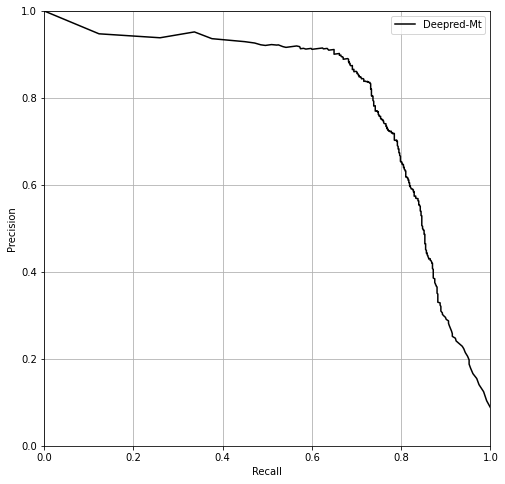

In [8]:
# Plot results
fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(rec, pre, c='black', label='Deepred-Mt')

plt.xlabel('Recall')
plt.ylabel('Precision')

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.grid(True)
plt.legend()

plt.show()